In [1]:
from models.utils import *
from models.ESN_clean_numpy import ESN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
from scipy import linalg
from scipy import sparse as sparse
from scipy.sparse import linalg as splinalg
from scipy.stats import norm
from sklearn.decomposition import PCA
from dysts.datasets import *
import esig
import os

%load_ext autoreload
%autoreload 2

/home/fbaturst/Desktop/reservoir-computing-dysts


## Use this boilerplate code to generate trajectories from the Lorenz using the dysts package

In [2]:
from dysts.flows import Lorenz

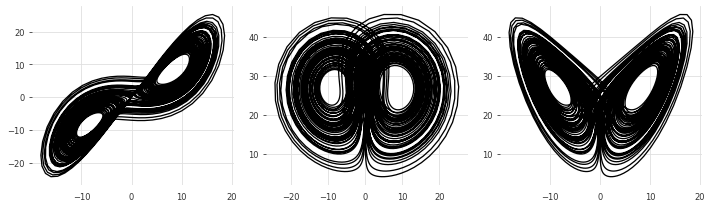

In [3]:
dynm_system = Lorenz()
sol = dynm_system.make_trajectory(5000)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
axes[0].plot(sol[:, 0], sol[:, 1])
axes[1].plot(sol[:, 1], sol[:, 2])
axes[2].plot(sol[:, 0], sol[:, 2])
plt.tight_layout()

## Author also provides API to get the test and train data he used for experiments

(1200, 1)
(1200, 1)


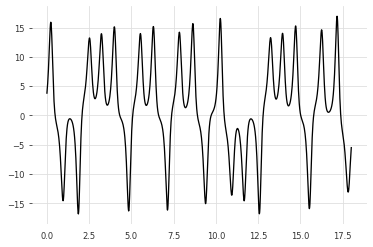

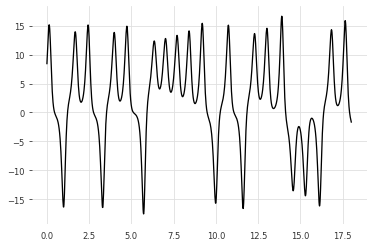

In [4]:
plt.figure()
train_set = load_dataset(subsets="train_all", data_format="pandas", granularity='fine', standardize=False)
plt.plot(np.array(train_set.loc["Lorenz"][["time"]]), np.array(train_set.loc["Lorenz"][["values"]]))

plt.figure()
test_set = load_dataset(subsets="test_all", data_format="pandas", granularity='fine', standardize=False)
plt.plot(np.array(test_set.loc["Lorenz"][["time"]]), np.array(test_set.loc["Lorenz"][["values"]]))

print(np.array(train_set.loc["Lorenz"][["values"]]).shape) # number of all points in the train timeseries
print(np.array(test_set.loc["Lorenz"][["values"]]).shape)  # number of all points in the test timeseries

## The input to the reservoir is just the x-coordinate of the Lorenz dynamics, here you can set hyperparameters

In [27]:
data = sol[:, 0] # just take the x coordinate of the Lorenz dynamics

trainLen = 3000
testLen = 1000
initLen = 200

inSize = outSize = 1
reservoir_size = 500
sparsity = 0.1
radius = 0.98                 # TODO In the Hankel view, does larger radius correspond to more memory of the system or less??
alpha = 0.75                   # leaking rate
reg = 1e-7                     # regularization coefficient
Win_scaling = 1                # Harts thesis used the W_in scaling factor of 0.02
initialize_reservoir_0 = True  # set to True if you want the first reservoir state to be zero
seed=1

## Load best found hyperparameters dictionary that I found during grid search. The hyperparameters found were for different initial conditions, and also were validated using the SMAPE score

In [6]:
hyperparameter_path = os.getcwd() + "/benchmarks/hyperparameters/hyperparameters_" + "train_univariate__pts_per_period_100__periods_12" + "_ESN.json"
hyperparameters_file = open(hyperparameter_path)
hyperparameters = json.load(hyperparameters_file)

In [4]:
hyperparameters['MackeyGlass']['ESN'].items()

dict_items([('reservoir_size', 500), ('sparsity', 0.5), ('radius', 0.75), ('reg', 1e-05), ('alpha', 0.5)])

In [443]:
l = []
sparsities = []
reservoirs = []
alphas = []
radii = []
for system in hyperparameters.keys():
    
    d = hyperparameters[system]['ESN']
    sparsities.append(d['sparsity'])
    reservoirs.append(d['reservoir_size'])
    alphas.append(d['alpha'])
    radii.append(d['radius'])
    l.append(tuple(d.items()))

In [444]:
freq_sparsities = Counter(sparsities)
freq_reservoirs = Counter(reservoirs)
freq_alphas = Counter(alphas)
freq_radii = Counter(radii)
print(freq_sparsities, freq_reservoirs, freq_alphas, freq_radii)

Counter({0.1: 83, 0.5: 49}) Counter({500: 46, 1000: 44, 250: 42}) Counter({0.5: 59, 0.75: 38, 1.0: 35}) Counter({0.95: 75, 0.5: 31, 0.75: 26})


In [446]:
freq = Counter(l)
for item in freq.most_common(5):
    
    print(item)

((('reservoir_size', 250), ('sparsity', 0.1), ('radius', 0.95), ('reg', 1e-07), ('alpha', 0.5)), 9)
((('reservoir_size', 500), ('sparsity', 0.1), ('radius', 0.95), ('reg', 1e-07), ('alpha', 0.5)), 6)
((('reservoir_size', 1000), ('sparsity', 0.1), ('radius', 0.95), ('reg', 1e-07), ('alpha', 0.5)), 6)
((('reservoir_size', 250), ('sparsity', 0.1), ('radius', 0.95), ('reg', 1e-07), ('alpha', 0.75)), 5)
((('reservoir_size', 500), ('sparsity', 0.1), ('radius', 0.95), ('reg', 1e-07), ('alpha', 0.75)), 5)


##  Fit the ESN on a long trajectory of the Lorenz dynamics

In [19]:
esn = ESN(reservoir_size=reservoir_size, sparsity=sparsity, radius=radius, reg=reg, alpha=alpha, initLen=initLen, initialize_reservoir_0=initialize_reservoir_0)

In [93]:
from numpy import linalg
from scipy import linalg as splinalg

reservoir_matrix = esn.W.todense()
print(linalg.cond(reservoir_matrix))
print(linalg.matrix_rank(reservoir_matrix))

53376.81165179698
500


In [50]:
U, sing_vals, Vt  = linalg.svd(reservoir_matrix)

sing_vals_trunc = np.copy(sing_vals)
sing_vals_trunc += 0.001
sing_vals_trunc = np.diag(sing_vals_trunc)

reservoir_matrix_appr = U @ sing_vals_trunc @ Vt

print(linalg.cond(reservoir_matrix_appr))

esn.W = reservoir_matrix_appr

843.9279348644586


In [28]:
esn.fit(data[0:trainLen])

In [29]:
predictions = esn.predict(testLen)

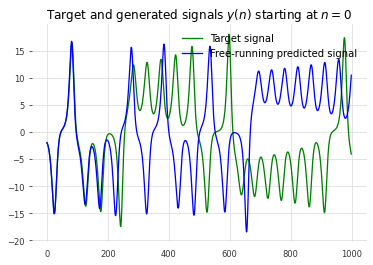

In [30]:
plt.plot(data[trainLen:trainLen+testLen], 'g' )
plt.plot(np.squeeze(predictions), 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

## Compute the signature of the stream and the reservoir dynamics in order to see if the signatures are matching

In [128]:
single_dynamics_sig = esig.stream2sig(data.reshape(-1, 1), depth=1)
full_dynamics_sig = esig.stream2sig(sol, depth=1)
print(single_dynamics_sig)
print(full_dynamics_sig)

[1.         9.58936951]
[ 1.          9.58936951 15.89321306 -0.42640927]


In [120]:
predictions_sig = esig.stream2sig(predictions, depth=1)
print(predictions_sig)

[ 1.         -8.05471651]


In [124]:
reservoir_dynamics_sig = esig.stream2sig(X_transformed.T, depth=1)
print(reservoir_dynamics_sig)

[ 1.         -2.97186845  3.28060539 -0.36100319]


## To test whether in the autonomous phase the reservoir dynamics match the dynamics of the underlying attractor, we project the reservoir states matrix onto its principal componets to reduce the dimensionality of the reservoir states

In [121]:
U, s, Vh = linalg.svd(esn.X_test.T)

In [122]:
principal_comp =  Vh[0:3, :]

In [123]:
X_transformed = principal_comp @ esn.X_test

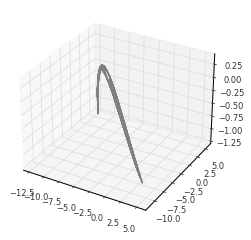

In [125]:
ax = plt.axes(projection='3d')
ax.plot3D(X_transformed[0, :], X_transformed[1, :], X_transformed[2, :], 'gray')

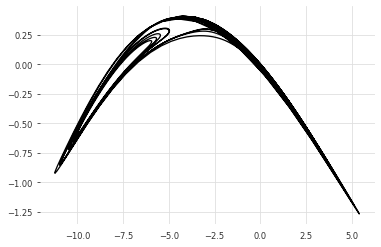

In [126]:
plt.plot(X_transformed[1, :], X_transformed[2, :])